In [1]:
import pandas as pd
import numpy as np
import json
import os
import pickle

seed = 123

# Data ingestion

Load pickled dataset, store as csv locally and on box. Then convert to a huggingface-friendly dataset.

In [2]:
# Load the bulk news documents
file_path = '../data/mediation_search_results.pkl'
with open(file_path, 'rb') as infile:
    try:
        data = pickle.load(infile)
    except Exception as e:
        raise e

# Examine data frame
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 107611 entries, 0 to 107610
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Document.DocumentId  107611 non-null  object
 1   Document.Content     107611 non-null  object
 2   Source.Name          107611 non-null  object
 3   ConfirmedMediation   107611 non-null  bool  
 4   title                106156 non-null  object
 5   author               33642 non-null   object
 6   publication_date     107611 non-null  object
 7   body_text            107604 non-null  object
 8   search_str           107611 non-null  object
 9   lang                 107611 non-null  object
dtypes: bool(1), object(9)
memory usage: 7.5+ MB


In [3]:
# Add language column
data['lang'].value_counts(normalize=True)

en    0.965914
fr    0.024291
de    0.003308
nl    0.003002
es    0.001998
it    0.000836
da    0.000186
pt    0.000112
ms    0.000084
sp    0.000084
af    0.000065
ru    0.000037
id    0.000019
br    0.000019
ar    0.000009
tl    0.000009
bg    0.000009
bn    0.000009
sw    0.000009
Name: lang, dtype: float64

In [4]:
# Ensure en and EN both are english
data.loc[data['lang'] == 'EN']['body_text']

Series([], Name: body_text, dtype: object)

In [5]:
# convert all language strings to lower
data['lang'] = data['lang'].str.lower()
data['lang'].value_counts(normalize=True)

en    0.965914
fr    0.024291
de    0.003308
nl    0.003002
es    0.001998
it    0.000836
da    0.000186
pt    0.000112
ms    0.000084
sp    0.000084
af    0.000065
ru    0.000037
id    0.000019
br    0.000019
ar    0.000009
tl    0.000009
bg    0.000009
bn    0.000009
sw    0.000009
Name: lang, dtype: float64

In [6]:
# Subset to english only
en_idx = (data['lang'] == 'en')
en_data = data.loc[en_idx]
en_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 103943 entries, 0 to 107610
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Document.DocumentId  103943 non-null  object
 1   Document.Content     103943 non-null  object
 2   Source.Name          103943 non-null  object
 3   ConfirmedMediation   103943 non-null  bool  
 4   title                102518 non-null  object
 5   author               31720 non-null   object
 6   publication_date     103943 non-null  object
 7   body_text            103936 non-null  object
 8   search_str           103943 non-null  object
 9   lang                 103943 non-null  object
dtypes: bool(1), object(9)
memory usage: 8.0+ MB


In [7]:
# How many non-english entries are mediation events?
en_and_med_idx = (data['lang'] != 'en') & (data['ConfirmedMediation'])
data.loc[en_and_med_idx].shape

(0, 10)

In [8]:
def df_to_csv(path, df, sep=';'):
    if not os.path.exists(path):
        print('CSV does not exist. Writing...')
        try:
            df.to_csv(path, index=False,  sep=sep)
        except Exception as e:
            raise e
        print('CSV saved.')
    else:
        print('CSV already exists.')

In [9]:
# Write to all to local csv
outfile = '../data/mediation_search_results-all.csv'
outfile_en = '../data/mediation_search_results-all_en.csv'

for f, df in zip([outfile, outfile_en], [data, en_data]):
    df_to_csv(f, df=df, sep=',')

CSV does not exist. Writing...
CSV saved.
CSV does not exist. Writing...
CSV saved.


In [9]:
# Check new nulls
null_idx = en_data['body_text'].isnull()
doc_ids = list(en_data.loc[null_idx]['Document.DocumentId'])
null_data = data[data['Document.DocumentId'].isin(doc_ids)] # Try to reparse these, otherwise drop
null_data.reset_index(inplace=True)
null_data

,index,Document.DocumentId,Document.Content,Source.Name,ConfirmedMediation,title,author,publication_date,body_text,search_str,lang
0,6543,7YXP-0B00-Y8Y1-P557-00000-00,"<entry xmlns=""http://www.w3.org/2005/Atom""><id...",The Leader-Post (Regina),False,Northern Ireland,None,2010-07-13T00:00:00Z,None,"(""United Kingdom"") AND [""Catholic"" OR ""Catholi...",en
1,6734,4M3X-P5R0-TX4T-G1X3-00000-00,"<entry xmlns=""http://www.w3.org/2005/Atom""><id...","The Hamilton Spectator (Ontario, Canada)",False,Top of the World,None,2006-10-14T00:00:00Z,None,"(""United Kingdom"") AND [""Catholic"" OR ""Catholi...",en
2,8863,511X-95P1-JBKX-9194-00000-00,"<entry xmlns=""http://www.w3.org/2005/Atom""><id...",Providence Journal,False,Historic meeting,None,2010-09-17T00:00:00Z,None,"(""United Kingdom"") AND [""Catholic"" OR ""Catholi...",en
3,19437,4M33-JX80-TWD3-Y3C6-00000-00,"<entry xmlns=""http://www.w3.org/2005/Atom""><id...",The Gazette (Montreal),False,A circle of nations,None,2006-10-10T00:00:00Z,None,"(Colombia) AND [""Indigenous People"" OR ""Indige...",en
4,23961,4MSP-91D0-TX4T-G1SD-00000-00,"<entry xmlns=""http://www.w3.org/2005/Atom""><id...","The Hamilton Spectator (Ontario, Canada)",False,TOP OF THE WORLD,None,2007-01-10T00:00:00Z,None,"(India) AND [""Assamese""] AND [mediat* OR envoy...",en
5,49930,4N54-YFX0-TX4T-G213-00000-00,"<entry xmlns=""http://www.w3.org/2005/Atom""><id...","The Hamilton Spectator (Ontario, Canada)",False,TOP OF THE WORLD,None,2007-02-28T00:00:00Z,None,(Sri Lanka) AND [Muslim*] AND [mediat* OR envo...,en
6,58301,4JB8-2P70-TWD4-03C5-00000-00,"<entry xmlns=""http://www.w3.org/2005/Atom""><id...",The Vancouver Sun (British Columbia),False,None,None,2006-02-23T00:00:00Z,None,(Sri Lanka) AND [Muslim*] AND [mediat* OR envo...,en


In [10]:
# Reset kernel
%reset -f

import pandas as pd
import numpy as np
import json
import os
import pickle

seed = 123

# Load english only data
file_path = '../data/mediation_search_results-all_en.csv'
data = pd.read_csv(file_path, sep=',')


## Descriptive Stats

### Proportion of mediation events in the data set.

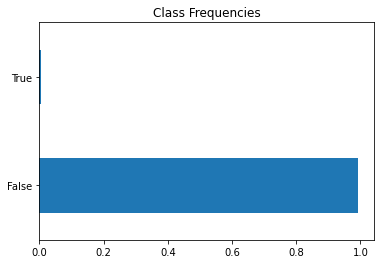

In [17]:
import matplotlib.pyplot as plt

data['ConfirmedMediation'].value_counts(normalize=True).plot.barh()
plt.title('Class Frequencies')
plt.show()

In [18]:
round(data['ConfirmedMediation'].value_counts(normalize=True) * 100, 2)

False    99.37
True      0.63
Name: ConfirmedMediation, dtype: float64

Mediation events are extremely rare. We will need to upsample positive instances or down sample negative instances to improve the model. Additionally, the train/validation/test split will need to be stratified.

### Examples of positive classes

In [19]:
def display_n_positive_entries(n=5, colname='body_text', seed=np.random.randint(1e6)):
    # Get array of positive cases indices
    positive_idx = data['ConfirmedMediation']
    positive_idx_array = data[positive_idx].index.values
    
    # Sample N indices
    np.random.seed(seed)
    index_sample = list(np.random.choice(positive_idx_array, n, replace=False))
    pd.set_option('display.max_colwidth', None)
    print(data.iloc[index_sample, :][colname])
    pd.set_option('display.max_colwidth', 100)


In [20]:
# Compare DocumentContent with Parsed test
display_n_positive_entries(n=1, colname='Document.Content', seed=seed)

77509    <entry xmlns="http://www.w3.org/2005/Atom"><id>urn:contentItem:3SKG-CPN0-0001-X0SD-00000-00</id><title>Burmese troops enter warlord's base</title><published>1996-01-03T00:00:00Z</published><updated>2022-04-11T13:58:25Z</updated><author><name>LexisNexis</name></author><content type="application/xml"><!--Transformation version 1.27--><articleDoc xmlns="" xmlns:xsi="http://www.w3.org/2001/XMLSchema-instance" xsi:noNamespaceSchemaLocation="http://www.lexisnexis.com/xmlschemas/content/public/articledoc/1/" schemaVersion="1.8" xml:lang="en"><articleDocHead><itemInfo><sourceSectionInfo><positionSection>International</positionSection></sourceSectionInfo></itemInfo></articleDocHead><nitf:body xmlns:nitf="http://iptc.org/std/NITF/2006-10-18/"><nitf:body.head><nitf:hedline><nitf:hl1>Burmese troops enter warlord's base</nitf:hl1></nitf:hedline><nitf:byline>BY JOHN HAIL</nitf:byline><nitf:dateline>BANGKOK, Jan. 3</nitf:dateline></nitf:body.head><nitf:body.content><bodyText><p nitf:lede="tr

In [21]:
display_n_positive_entries(n=1, colname='body_text', seed=123)

77509    Burmese troops have entered the jungle stronghold of Shan Warlord Khun Sa as part of a negotiated cease-fire in one of Asia's oldest insurgencies, Shan rebel sources said Wednesday.  The sources said about 100 Burmese soldiers entered Homong, headquarters of Khun Sa's Muang Tai Army, on New Year's Day following the arrival of six Burmese officers a couple of days earlier.  ''It's not a surrender. They've made a deal. Khun Sa is still there,'' said one source who spoke on condition of anonymity.  Khun Sa, alias Chiang Shi Fu, 61, is reputed to be the world's biggest heroin dealer, controlling the bulk of opium production and refining in the so-called Golden Triangle tri-border region of Thailand, Burma and Laos.  He has been indicted by a U.S. federal court on narcotics charges.  Khun Sa is the most powerful leader of Burma's Shan ethnic minority, which has been fighting for independence from Rangoon since 1948.  Although the Shan people have rallied to his banner, many have ex

### How long are our documents on average?

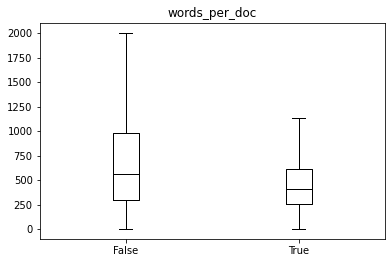

In [23]:
data['words_per_doc'] = data['body_text'].dropna().str.split().apply(len)
data.boxplot(
    "words_per_doc", 
    by="ConfirmedMediation",
    grid=False,
    showfliers=False,
    color="black"
    )
plt.suptitle("")
plt.xlabel("")
plt.show()

Most mediation documents are shorter than 750 tokens whereas the null class has a much larger spread with over half being longer than 500 tokens. Unless we want to significantly truncate our examples, we cannot use DistilBERT (512 tokens max). One option is [Longformer](https://huggingface.co/docs/transformers/v4.18.0/en/model_doc/longformer). 

# Create Dataset

Use imbalanced-learn library to create train/test split datasets and perform resampling (up- and down-sampling) *within* each split to create more informative data for training on. This still might not be enough to obtain good results given the class imbalances.

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Create raw dataframe
raw_data = data[['body_text', 'ConfirmedMediation', 'search_str']].rename(columns={
    'body_text': 'text', 
    'ConfirmedMediation': 'label',
    'search_str': 'dispute'
    })
raw_data['label'] = (raw_data['label'] == True).astype(int)

# Drop nas
raw_data.dropna(inplace=True)

# Subset dataset columns to features and targets
X = raw_data[['text', 'dispute']]
label = raw_data['label']

# Create stratified train/test split
X_train, X_test, label_train, label_test = train_test_split(X, label,
                                                            test_size=0.3,
                                                            random_state=123,
                                                            stratify=label)

# Save dispute search strings separately
dispute_train, dispute_test = X_train['dispute'], X_test['dispute']
text_train, text_test = X_train['text'], X_test['text']

# Combine into train/test split dataframes and save as hugging face dataset
train_raw = pd.concat([text_train, label_train], axis=1)
test_raw = pd.concat([text_test, label_test], axis=1)

In [21]:
def df_to_csv(path, df, sep=';', index=False):
    if not os.path.exists(path):
        print('CSV does not exist. Writing...')
        try:
            df.to_csv(path, index=index,  sep=sep)
        except Exception as e:
            raise e
        print('CSV saved.')
    else:
        print('CSV already exists.')

# Save splits to json
base_path = '../data/mediation_search_results'
for split, df in zip(['train', 'test'], [train_raw, test_raw]):
    outfile = f'{base_path}-{split}.csv'
    df_to_csv(outfile, df=df, sep=',')
    
base_path = '../data/dispute_string'
for split, df in zip(['train', 'test'], [dispute_train, dispute_test]):
    outfile = f'{base_path}-{split}.csv'
    df_to_csv(outfile, df=df, sep=',', index=True)

CSV already exists.
CSV already exists.
CSV does not exist. Writing...
CSV saved.
CSV does not exist. Writing...
CSV saved.


In [2]:
# Write training and testing splits to box

# Instantiate box client and write to box
from boxsdk import DevelopmentClient
import configparser

# Read in configuration variables
parser = configparser.ConfigParser()
parser.read("../pipeline.conf")

client = DevelopmentClient()

In [3]:
# Retrieve mediation project folder info
folder_id = parser.get("umd_box_credentials", "OTHER_DOCUMENTS_FOLDER_ID")
other_documents_folder = client.folder(folder_id=folder_id).get()


GET https://api.box.com/2.0/folders/144471737937 {'headers': {'Authorization': '---SrIF',
             'User-Agent': 'box-python-sdk-3.4.0',
             'X-Box-UA': 'agent=box-python-sdk/3.4.0; env=python/3.10.4'},
 'params': None}
"GET https://api.box.com/2.0/folders/144471737937" 200 1942
{'Date': 'Wed, 24 Aug 2022 18:23:53 GMT', 'Content-Type': 'application/json', 'Transfer-Encoding': 'chunked', 'x-envoy-upstream-service-time': '223', 'etag': '"0"', 'box-request-id': '0d2c19a84b103fee3d98d83aa0865199', 'cache-control': 'no-cache, no-store', 'strict-transport-security': 'max-age=31536000', 'Via': '1.1 google', 'Alt-Svc': 'h3=":443"; ma=2592000,h3-29=":443"; ma=2592000,h3-Q050=":443"; ma=2592000,h3-Q046=":443"; ma=2592000,h3-Q043=":443"; ma=2592000,quic=":443"; ma=2592000; v="46,43"'}
{'content_created_at': '2021-08-28T07:59:31-07:00',
 'content_modified_at': '2022-08-24T11:19:07-07:00',
 'created_at': '2021-08-28T07:59:31-07:00',
 'created_by': {'id': '15074227686',
                

In [5]:
# Create subfolders if not already created
# and push data
dataset_paths = ['../data/mediation_search_results-test.csv', '../data/mediation_search_results-train.csv']

already_created = 'curation-pipeline' in [folder.name for folder in other_documents_folder.item_collection['entries']]
if not already_created:
    project_folder = other_documents_folder.create_subfolder('curation-pipeline')
    print(f"Created project subfolder with ID {project_folder.id}")
    
    # Create data subfolder
    data_folder = project_folder.create_subfolder('data')
    print(f"Created data subfolder with ID {data_folder.id}")
    
# Push train and test splits to box
for path in dataset_paths:
    chunked_uploader = client.folder(data_folder.id).get_chunked_uploader(path)
    try:
        uploaded_file = chunked_uploader.start()
    except:
        uploaded_file = chunked_uploader.resume()
    print(f'File "{uploaded_file.name}" uploaded to Box with file ID {uploaded_file.id}')
    